In [2]:
import logging; logging.basicConfig(level=logging.INFO)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import ltn
import pandas as pd

In [23]:
df = pd.read_csv("real-estate.csv")
df = df.sample(frac=1) #shuffle
df.head(5)

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
307,308,2012.833,10.3,3079.890,0,24.95460,121.56627,24.7
283,284,2013.417,33.5,1978.671,2,24.98674,121.51844,23.5
186,187,2013.167,20.9,2185.128,3,24.96322,121.51237,25.7
244,245,2013.083,4.8,1559.827,3,24.97213,121.51627,21.7
52,53,2013.583,32.1,1438.579,3,24.97419,121.51750,27.0


In [4]:
x = df[['X1 transaction date', 'X2 house age',
       'X3 distance to the nearest MRT station',
       'X4 number of convenience stores', 'X5 latitude', 'X6 longitude']]
y = df[['Y house price of unit area']]

batch_size=128
ds_train = tf.data.Dataset.from_tensor_slices((x[:330],y[:330])).batch(batch_size)
ds_test = tf.data.Dataset.from_tensor_slices((x[330:],y[330:])).batch(batch_size)

In [21]:
f = ltn.Function.MLP(input_shapes=[(6,)], output_shape=[1], hidden_layer_sizes=(8, 8))


ValueError: Invalid dtype: <property object at 0x0000020AA03318F0>

In [7]:
eq = ltn.Predicate.Lambda(
    #lambda args: tf.exp(-0.05*tf.sqrt(tf.reduce_sum(tf.square(args[0]-args[1]),axis=1)))        
    lambda args: 1/(1+0.5*tf.sqrt(tf.reduce_sum(tf.square(args[0]-args[1]),axis=1)))
)

In [8]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(p=2),semantics="exists")

In [18]:
def axioms(x_data, y_data):
    try:
        diag_xy = ltn.diag(x_data, y_data)
        print(f"diag_xy: {diag_xy}")
        
        eq_f_x_y = eq([f(x_data), y_data])
        print(f"eq_f_x_y: {eq_f_x_y}")
        
        forall_result = Forall(diag_xy, eq_f_x_y)
        print(f"forall_result: {forall_result}")
        
        sat_level = forall_result.tensor
        print(f"sat_level: {sat_level}")
        
        return sat_level
    except Exception as e:
        print(f"Error in axioms function: {e}")
        raise


In [19]:
for x, y in ds_test:
    try:
        print("Initial sat level %.5f" % axioms(x, y))
    except Exception as e:
        print(f"Error while evaluating axioms: {e}")
    break

Error in axioms function: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'free_vars'
Error while evaluating axioms: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'free_vars'


In [11]:
metrics_dict = {
    'train_sat': tf.keras.metrics.Mean(name='train_sat'),
    'test_sat': tf.keras.metrics.Mean(name='test_sat'),
    'train_accuracy': tf.keras.metrics.RootMeanSquaredError(name="train_accuracy"),
    'test_accuracy': tf.keras.metrics.RootMeanSquaredError(name="test_accuracy")
}
#Define the training and testing steps.

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
@tf.function
def train_step(x, y):
    # sat and update
    with tf.GradientTape() as tape:
        sat = axioms(x, y)
        loss = 1.-sat
    gradients = tape.gradient(loss, f.trainable_variables)
    optimizer.apply_gradients(zip(gradients, f.trainable_variables))
    sat = axioms(x, y)
    metrics_dict['train_sat'](sat)
    # accuracy
    metrics_dict['train_accuracy'](y,f.model(x))
    
@tf.function
def test_step(x, y):
    # sat
    sat = axioms(x, y)
    metrics_dict['test_sat'](sat)
    # accuracy
    metrics_dict['test_accuracy'](y,f.model(x))

In [24]:
import commons

EPOCHS = 1000

commons.train(
    EPOCHS,
    metrics_dict,
    ds_train,
    ds_test,
    train_step,
    test_step,
    csv_path="regression_results.csv",
    track_metrics=50
)

AttributeError: 'Mean' object has no attribute 'reset_states'

In [13]:
import seaborn as sns
sns.set(font_scale=1.2)

NameError: name 'f' is not defined

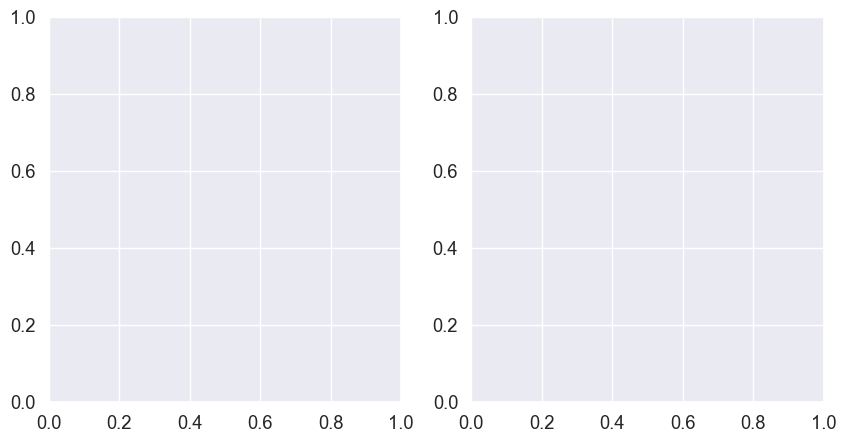

In [14]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
ax = axs[0]
data = {'y_pred':[],'y_true':[]}
for x,y in ds_train:
    data['y_pred'].extend(f.model(x)[:,0].numpy())
    data['y_true'].extend(y[:,0].numpy())
df = pd.DataFrame(data,columns=['y_pred','y_true'])
ax.set_xlim(0,80)
ax.set_ylim(0,80)
sns.regplot("y_true","y_pred",data=df,ax=ax,truncate=False,
            scatter_kws={'alpha':0.5},line_kws={'color':'r','alpha':0.3,'linestyle':'--','linewidth':2})
ax.plot([0,100],[0,100],color="gray",linestyle="--")
ax.set_xlabel("Actual y values")
ax.set_ylabel("Fitted y values")
ax.set_title("Training Data")

ax = axs[1]
data = {'y_pred':[],'y_true':[]}
for x,y in ds_test:
    data['y_pred'].extend(f.model(x)[:,0].numpy())
    data['y_true'].extend(y[:,0].numpy())
df = pd.DataFrame(data,columns=['y_pred','y_true'])
ax.set_ylim(0,80)
ax.set_xlim(0,80)
sns.regplot("y_true","y_pred",data=df,ax=ax,truncate=False,
            scatter_kws={'alpha':0.5},line_kws={'color':'r','alpha':0.3,'linestyle':'--','linewidth':2})
ax.plot([0,100],[0,100],color="gray",linestyle="--")
ax.set_xlabel("Actual y values")
ax.set_ylabel("Fitted y values")
ax.set_title("Test Data")
plt.tight_layout()
#plt.savefig("ex_regression.pdf")